In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\chroma'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 1 Results: Accuracy=0.57, Precision=0.58, Recall=0.57, F1=0.55, Training Time=663.36s, Testing Time=31.54s

Fold 2 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 2s/step
Fold 2 Results: Accuracy=0.67, Precision=0.67, Recall=0.67, F1=0.67, Training Time=1475.20s, Testing Time=5.70s

Fold 3 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 3 Results: Accuracy=0.41, Precision=0.40, Recall=0.41, F1=0.40, Training Time=668.07s, Testing Time=5.17s

Fold 4 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 4 Results: Accuracy=0.55, Precision=0.55, Recall=0.55, F1=0.55, Training Time=1272.65s, Testing Time=5.36s

Fold 5 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 5 Results: Accuracy=0.53, Precision=0.63, Recall=0.53, F1=0.43, Training Time=664.41s, Testin

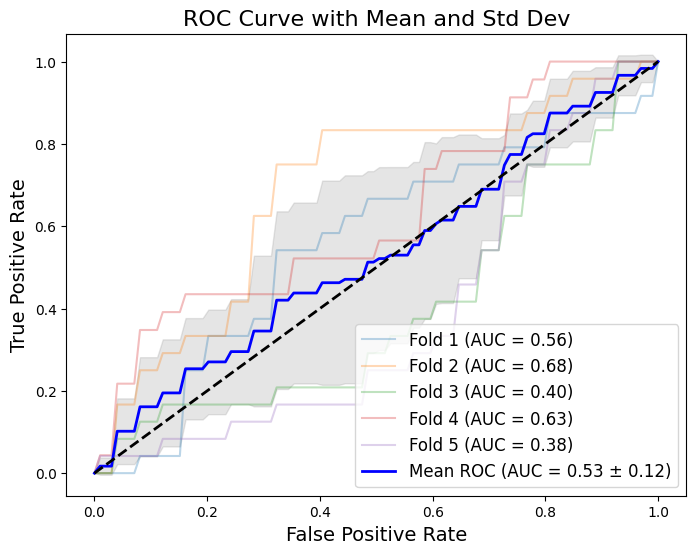

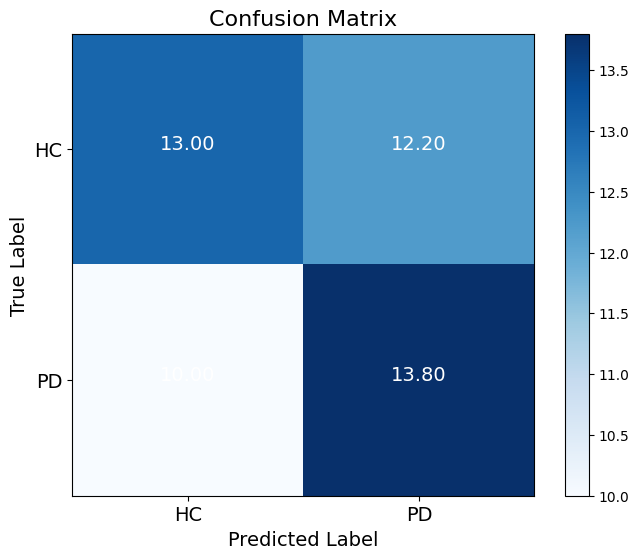

In [7]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\cqt'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 1 Results: Accuracy=0.49, Precision=0.48, Recall=0.49, F1=0.46, Training Time=773.07s, Testing Time=5.03s

Fold 2 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 2 Results: Accuracy=0.61, Precision=0.62, Recall=0.61, F1=0.61, Training Time=1332.84s, Testing Time=19.42s

Fold 3 - Speaker-Independent Evaluation
2/2 [==============================] - 4s 1s/step
Fold 3 Results: Accuracy=0.35, Precision=0.34, Recall=0.35, F1=0.34, Training Time=855.23s, Testing Time=19.23s

Fold 4 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 2s/step
Fold 4 Results: Accuracy=0.57, Precision=0.59, Recall=0.57, F1=0.57, Training Time=725.63s, Testing Time=27.04s

Fold 5 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 5 Results: Accuracy=0.45, Precision=0.38, Recall=0.45, F1=0.37, Training Time=839.49s, Testi

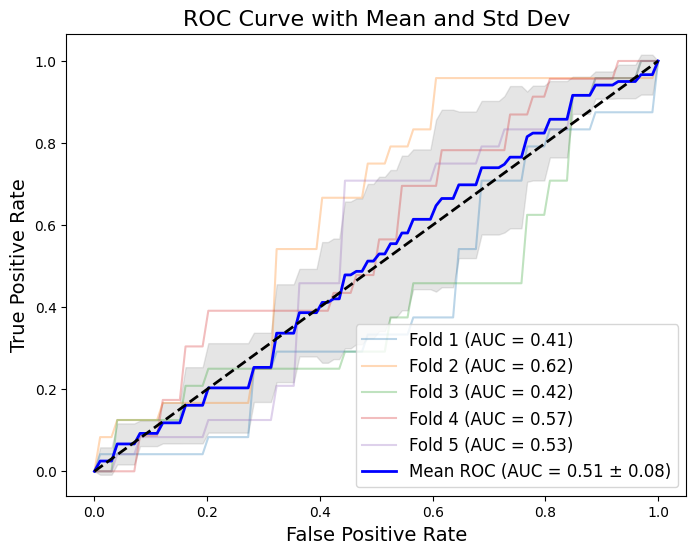

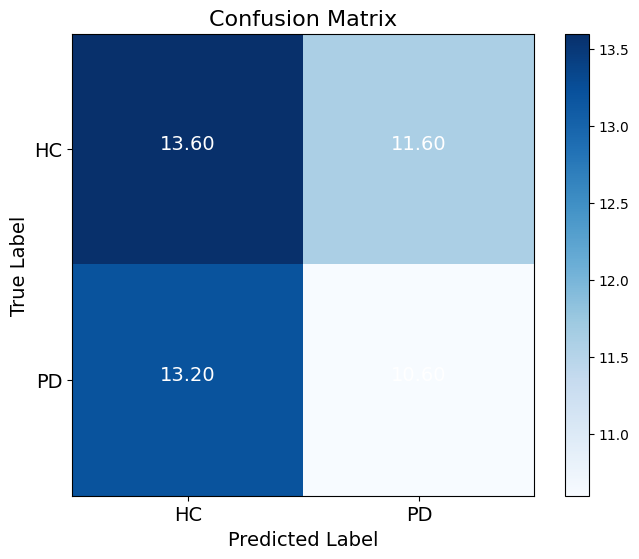

In [9]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mfcc'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 1 Results: Accuracy=0.51, Precision=0.26, Recall=0.51, F1=0.34, Training Time=806.29s, Testing Time=4.77s

Fold 2 - Speaker-Independent Evaluation
2/2 [==============================] - 4s 1s/step
Fold 2 Results: Accuracy=0.51, Precision=0.26, Recall=0.51, F1=0.34, Training Time=3051.05s, Testing Time=4.44s

Fold 3 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 2s/step
Fold 3 Results: Accuracy=0.51, Precision=0.51, Recall=0.51, F1=0.38, Training Time=939.96s, Testing Time=5.89s

Fold 4 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 4 Results: Accuracy=0.53, Precision=0.28, Recall=0.53, F1=0.37, Training Time=1453.48s, Testing Time=23.66s

Fold 5 - Speaker-Independent Evaluation
2/2 [==============================] - 6s 1s/step
Fold 5 Results: Accuracy=0.51, Precision=0.26, Recall=0.51, F1=0.34, Training Time=1397.86s, Testi

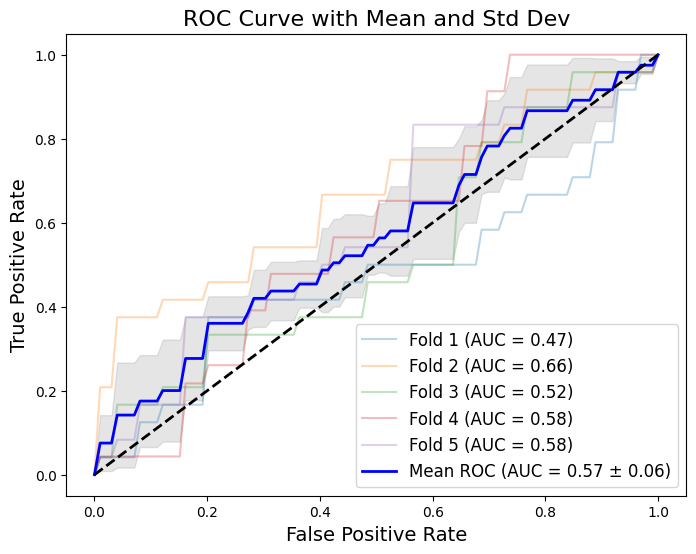

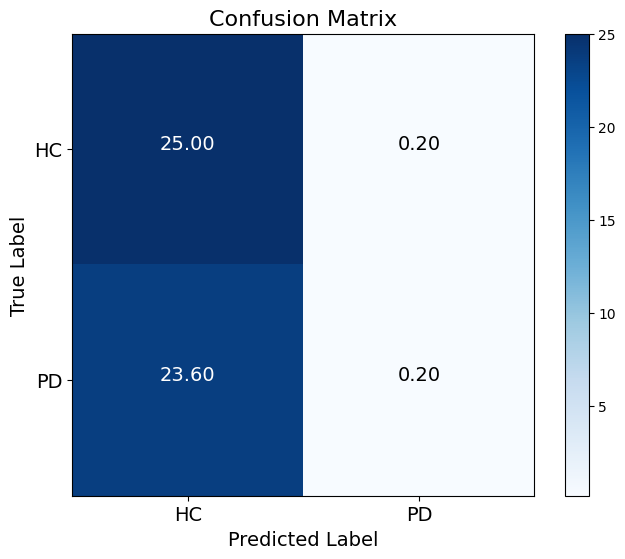

In [11]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, LeakyReLU, Multiply, Add, 
                                    MaxPooling2D, Flatten, Dense, 
                                    Activation, Concatenate, Input)
from tensorflow.keras.models import Model

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mel'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)  # Properly define input layer
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model




Fold 1 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 2s/step
Fold 1 Results: Accuracy=0.41, Precision=0.36, Recall=0.41, F1=0.36, Training Time=691.22s, Testing Time=63.29s

Fold 2 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 2 Results: Accuracy=0.65, Precision=0.66, Recall=0.65, F1=0.65, Training Time=1950.65s, Testing Time=5.73s

Fold 3 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 1s/step
Fold 3 Results: Accuracy=0.51, Precision=0.76, Recall=0.51, F1=0.37, Training Time=675.21s, Testing Time=13.27s

Fold 4 - Speaker-Independent Evaluation
2/2 [==============================] - 4s 2s/step
Fold 4 Results: Accuracy=0.47, Precision=0.45, Recall=0.47, F1=0.45, Training Time=1177.78s, Testing Time=4.44s

Fold 5 - Speaker-Independent Evaluation
2/2 [==============================] - 5s 2s/step
Fold 5 Results: Accuracy=0.53, Precision=0.76, Recall=0.53, F1=0.39, Training Time=740.01s, Testi

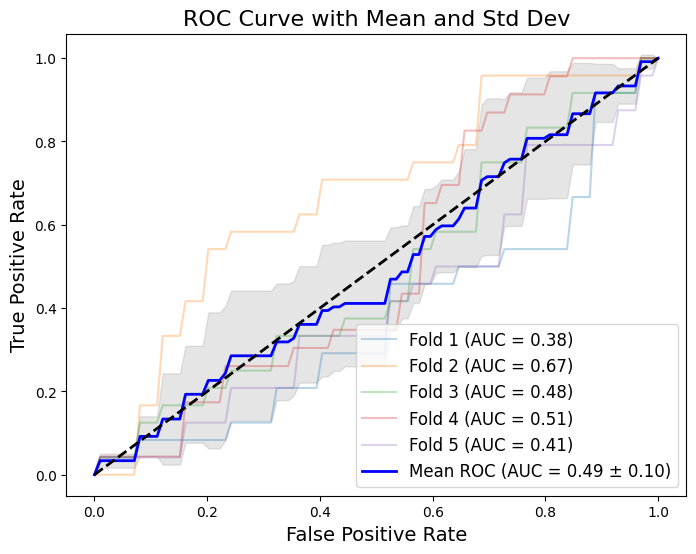

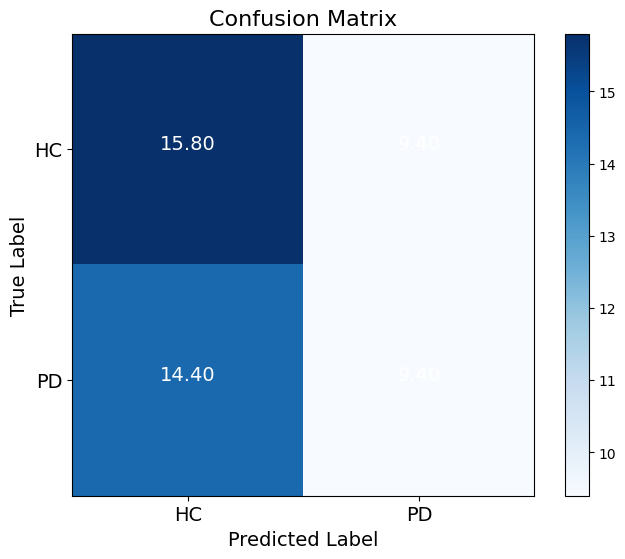

In [13]:
# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [9]:
#chroma

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 19s 2s/step - loss: 0.7350 - accuracy: 0.4847 - val_loss: 0.7266 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 7s 1s/step - loss: 0.7275 - accuracy: 0.4847 - val_loss: 0.7214 - val_accuracy: 0.4898
Epoch 3/50
7/7 [==============================] - 7s 1s/step - loss: 0.7230 - accuracy: 0.4847 - val_loss: 0.7165 - val_accuracy: 0.4898
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 0.7181 - accuracy: 0.4847 - val_loss: 0.7125 - val_accuracy: 0.4898
Epoch 5/50
7/7 [==============================] - 7s 1s/step - loss: 0.7143 - accuracy: 0.4847 - val_loss: 0.7097 - val_accuracy: 0.4898
Epoch 6/50
7/7 [==============================] - 7s 1s/step - loss: 0.7116 - accuracy: 0.4847 - val_loss: 0.7069 - val_accuracy: 0.4898
Epoch 7/50
7/7 [=======================

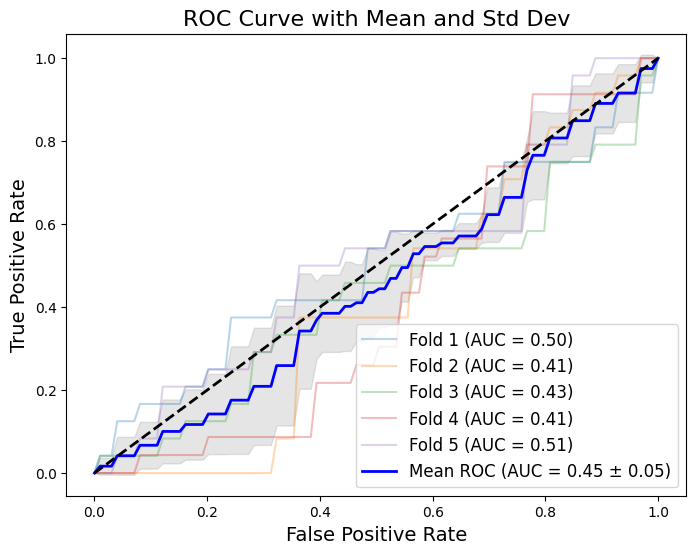

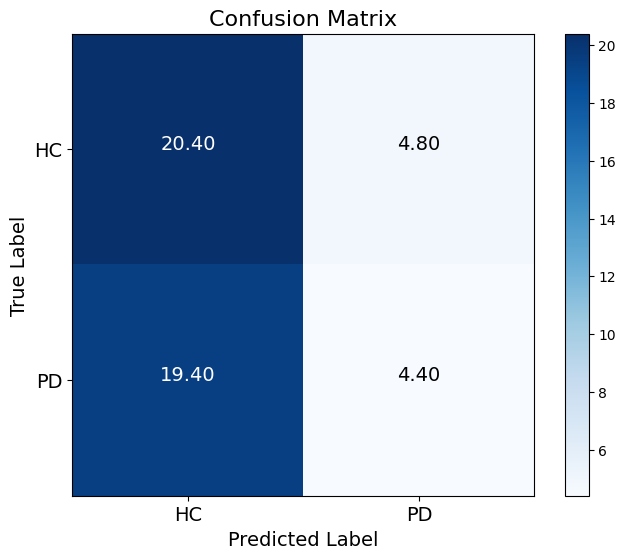

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\chroma'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_resnet50_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 13s 910ms/step - loss: 0.7414 - accuracy: 0.5153 - val_loss: 0.7695 - val_accuracy: 0.4286
Epoch 2/50
7/7 [==============================] - 3s 366ms/step - loss: 0.7246 - accuracy: 0.5102 - val_loss: 0.7623 - val_accuracy: 0.4082
Epoch 3/50
7/7 [==============================] - 2s 344ms/step - loss: 0.7126 - accuracy: 0.5051 - val_loss: 0.7580 - val_accuracy: 0.4286
Epoch 4/50
7/7 [==============================] - 3s 416ms/step - loss: 0.7043 - accuracy: 0.5000 - val_loss: 0.7563 - val_accuracy: 0.4490
Epoch 5/50
7/7 [==============================] - 2s 345ms/step - loss: 0.6990 - accuracy: 0.5204 - val_loss: 0.7554 - val_accuracy: 0.4286
Epoch 6/50
7/7 [==============================] - 3s 385ms/step - loss: 0.6943 - accuracy: 0.5255 - val_loss: 0.7552 - val_accuracy: 0.4286
Epoch 7/50
7/7 [=====

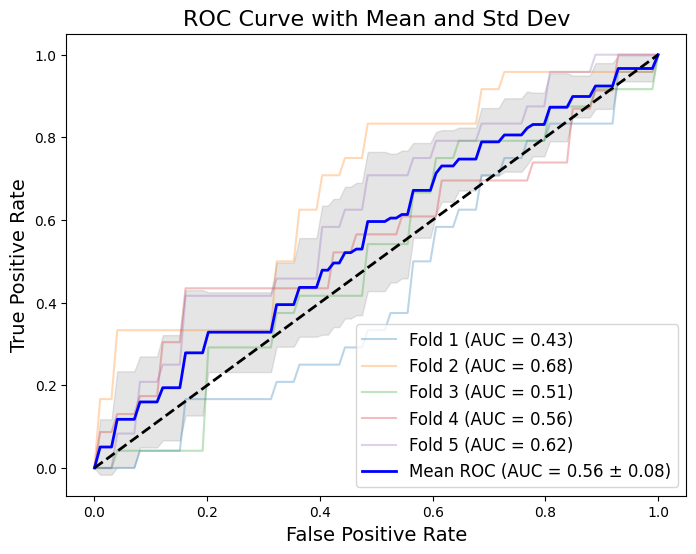

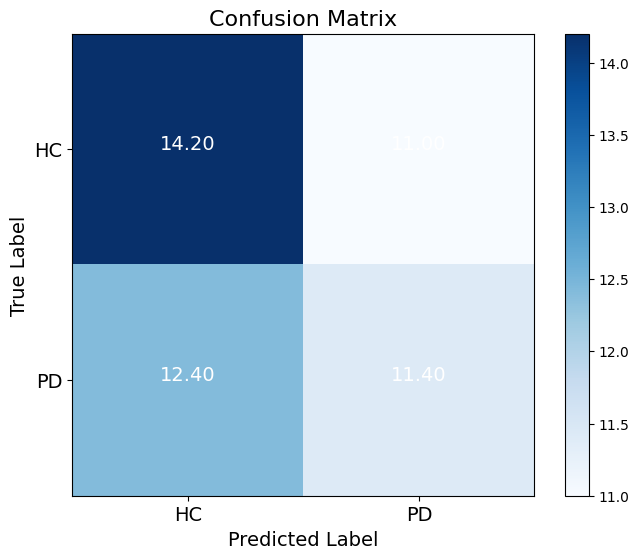

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\chroma'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_mobilenetv2_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 31s 4s/step - loss: 0.7098 - accuracy: 0.4796 - val_loss: 0.7197 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 26s 4s/step - loss: 0.7064 - accuracy: 0.4796 - val_loss: 0.7164 - val_accuracy: 0.4898
Epoch 3/50
7/7 [==============================] - 24s 4s/step - loss: 0.7040 - accuracy: 0.5000 - val_loss: 0.7141 - val_accuracy: 0.4898
Epoch 4/50
7/7 [==============================] - 24s 3s/step - loss: 0.7013 - accuracy: 0.5051 - val_loss: 0.7121 - val_accuracy: 0.4898
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 0.6999 - accuracy: 0.5204 - val_loss: 0.7107 - val_accuracy: 0.5102
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 0.6988 - accuracy: 0.5255 - val_loss: 0.7100 - val_accuracy: 0.4898
Epoch 7/50
7/7 [==================

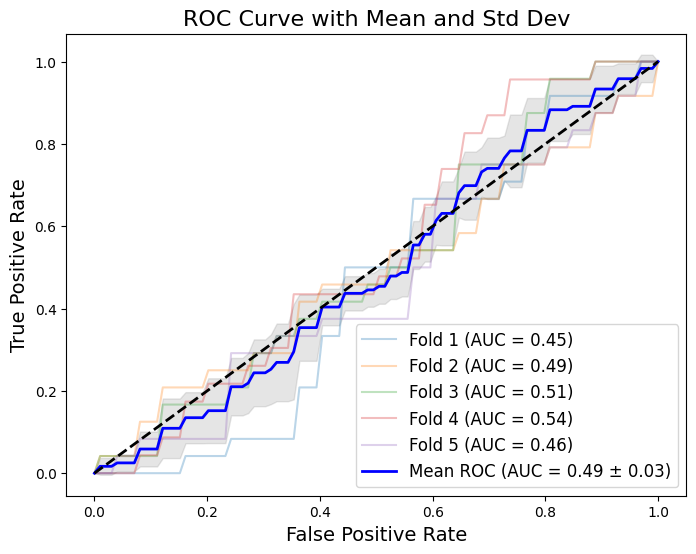

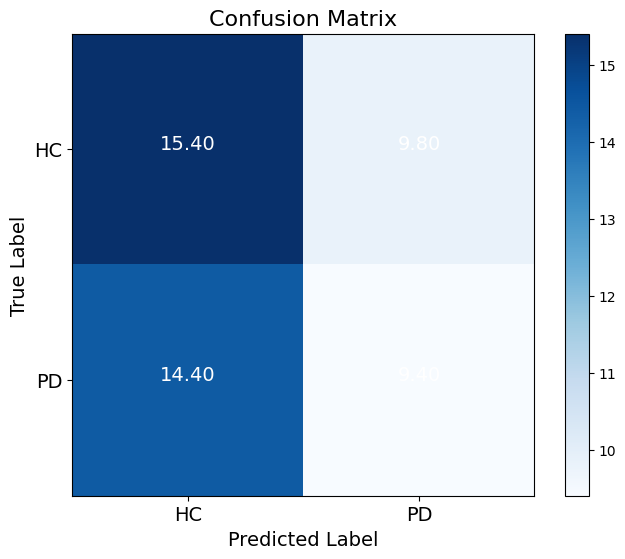

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\chroma'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_vgg19_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [ ]:
#Mel

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 38s 3s/step - loss: 0.6886 - accuracy: 0.5051 - val_loss: 0.6955 - val_accuracy: 0.5510
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 0.6882 - accuracy: 0.5000 - val_loss: 0.6955 - val_accuracy: 0.5306
Epoch 3/50
7/7 [==============================] - 11s 2s/step - loss: 0.6880 - accuracy: 0.5102 - val_loss: 0.6955 - val_accuracy: 0.5510
Epoch 4/50
7/7 [==============================] - 11s 2s/step - loss: 0.6881 - accuracy: 0.5051 - val_loss: 0.6955 - val_accuracy: 0.5510
Epoch 5/50
7/7 [==============================] - 11s 2s/step - loss: 0.6880 - accuracy: 0.5000 - val_loss: 0.6955 - val_accuracy: 0.5102
Epoch 6/50
7/7 [==============================] - 11s 2s/step - loss: 0.6878 - accuracy: 0.5255 - val_loss: 0.6955 - val_accuracy: 0.5510
Epoch 7/50
7/7 [==================

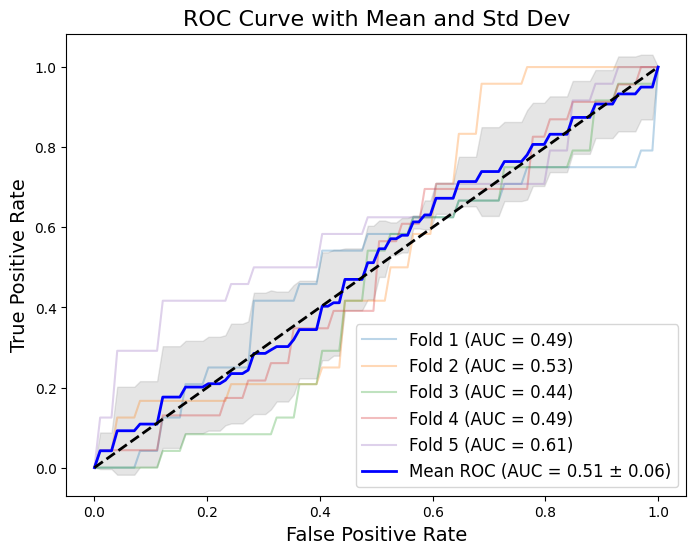

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mel'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_resnet50_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 23s 962ms/step - loss: 0.7422 - accuracy: 0.4847 - val_loss: 0.7431 - val_accuracy: 0.4082
Epoch 2/50
7/7 [==============================] - 4s 601ms/step - loss: 0.7266 - accuracy: 0.5000 - val_loss: 0.7374 - val_accuracy: 0.4286
Epoch 3/50
7/7 [==============================] - 4s 517ms/step - loss: 0.7163 - accuracy: 0.5408 - val_loss: 0.7343 - val_accuracy: 0.4286
Epoch 4/50
7/7 [==============================] - 4s 572ms/step - loss: 0.7097 - accuracy: 0.5663 - val_loss: 0.7333 - val_accuracy: 0.4490
Epoch 5/50
7/7 [==============================] - 4s 580ms/step - loss: 0.7040 - accuracy: 0.5510 - val_loss: 0.7328 - val_accuracy: 0.4694
Epoch 6/50
7/7 [==============================] - 4s 502ms/step - loss: 0.6998 - accuracy: 0.5510 - val_loss: 0.7319 - val_accuracy: 0.4898
Epoch 7/50
7/7 [=====

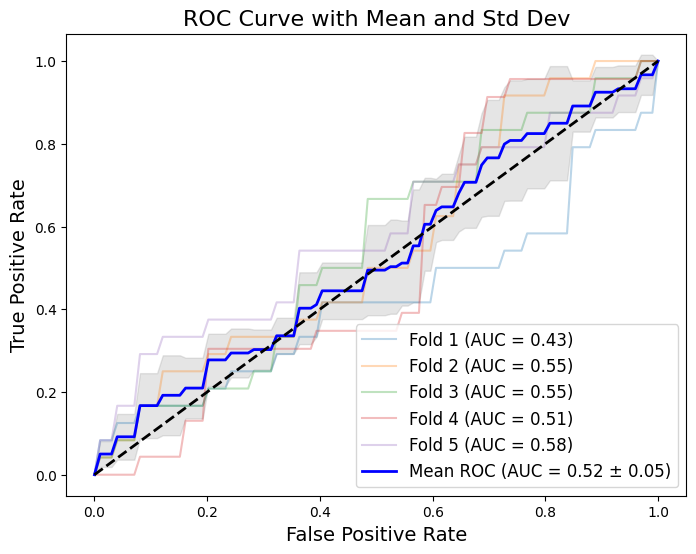

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mel'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_mobilenetv2_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 29s 4s/step - loss: 0.7893 - accuracy: 0.5153 - val_loss: 0.7633 - val_accuracy: 0.5102
Epoch 2/50
7/7 [==============================] - 25s 4s/step - loss: 0.7777 - accuracy: 0.5153 - val_loss: 0.7515 - val_accuracy: 0.5102
Epoch 3/50
7/7 [==============================] - 26s 4s/step - loss: 0.7664 - accuracy: 0.5153 - val_loss: 0.7420 - val_accuracy: 0.5102
Epoch 4/50
7/7 [==============================] - 26s 4s/step - loss: 0.7580 - accuracy: 0.5153 - val_loss: 0.7351 - val_accuracy: 0.5102
Epoch 5/50
7/7 [==============================] - 25s 4s/step - loss: 0.7505 - accuracy: 0.5153 - val_loss: 0.7278 - val_accuracy: 0.5102
Epoch 6/50
7/7 [==============================] - 25s 4s/step - loss: 0.7428 - accuracy: 0.5153 - val_loss: 0.7210 - val_accuracy: 0.5102
Epoch 7/50
7/7 [==================

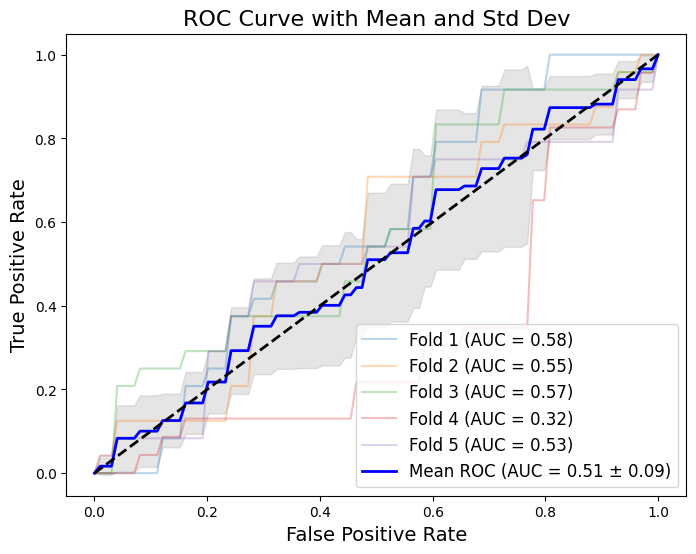

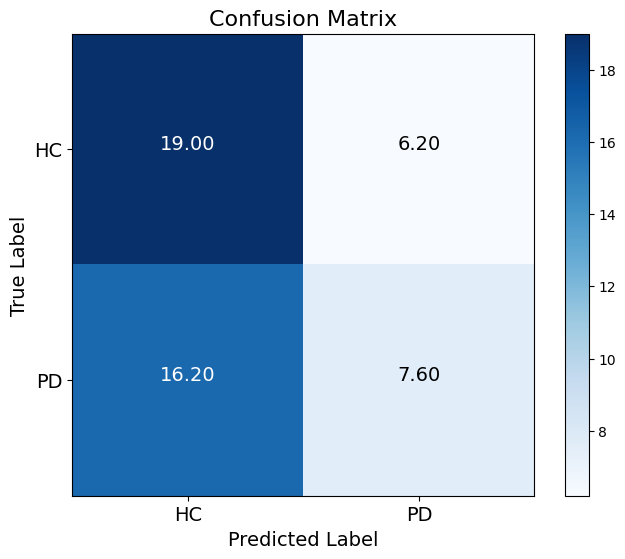

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\chroma'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_vgg19_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [ ]:
#FOR MFCC

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 42s 3s/step - loss: 0.6954 - accuracy: 0.4847 - val_loss: 0.6953 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 0.6948 - accuracy: 0.4847 - val_loss: 0.6946 - val_accuracy: 0.4898
Epoch 3/50
7/7 [==============================] - 15s 2s/step - loss: 0.6940 - accuracy: 0.4847 - val_loss: 0.6943 - val_accuracy: 0.4898
Epoch 4/50
7/7 [==============================] - 16s 2s/step - loss: 0.6938 - accuracy: 0.4847 - val_loss: 0.6942 - val_accuracy: 0.4898
Epoch 5/50
7/7 [==============================] - 16s 2s/step - loss: 0.6937 - accuracy: 0.4847 - val_loss: 0.6942 - val_accuracy: 0.4898
Epoch 6/50
7/7 [==============================] - 15s 2s/step - loss: 0.6936 - accuracy: 0.4847 - val_loss: 0.6941 - val_accuracy: 0.4898
Epoch 7/50
7/7 [==================

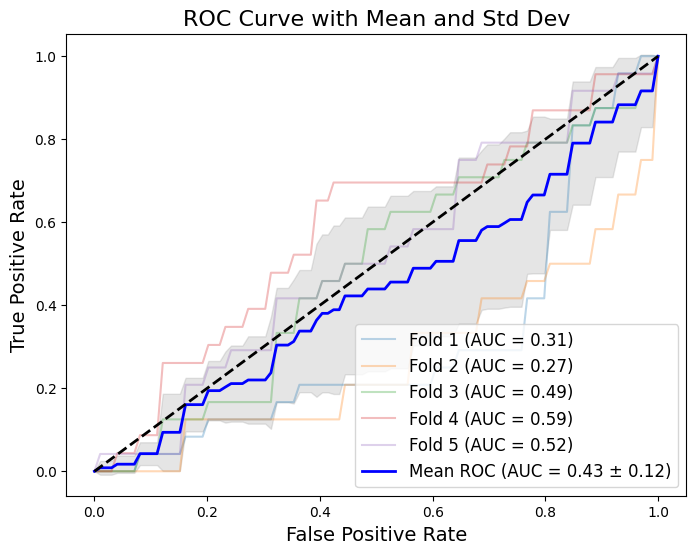

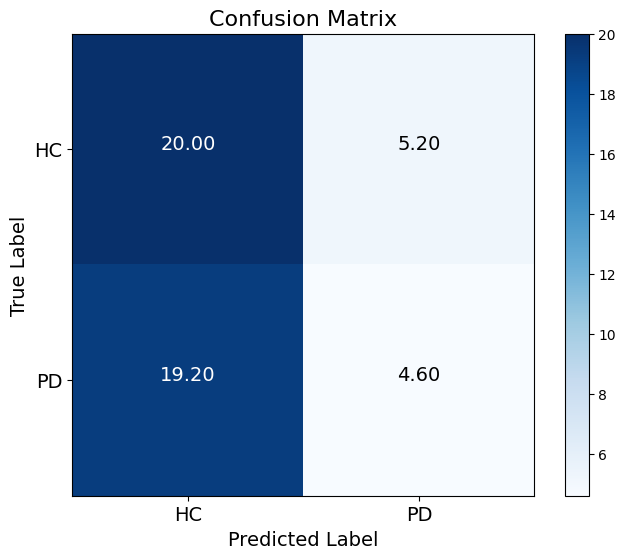

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mfcc'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_resnet50_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 26s 2s/step - loss: 0.7344 - accuracy: 0.4796 - val_loss: 0.7087 - val_accuracy: 0.5102
Epoch 2/50
7/7 [==============================] - 5s 772ms/step - loss: 0.7183 - accuracy: 0.4796 - val_loss: 0.7038 - val_accuracy: 0.5306
Epoch 3/50
7/7 [==============================] - 5s 790ms/step - loss: 0.7111 - accuracy: 0.4796 - val_loss: 0.7042 - val_accuracy: 0.5102
Epoch 4/50
7/7 [==============================] - 5s 816ms/step - loss: 0.7099 - accuracy: 0.4745 - val_loss: 0.7064 - val_accuracy: 0.5102
Epoch 5/50
7/7 [==============================] - 5s 733ms/step - loss: 0.7084 - accuracy: 0.5204 - val_loss: 0.7092 - val_accuracy: 0.5102
Epoch 6/50
7/7 [==============================] - 5s 777ms/step - loss: 0.7069 - accuracy: 0.5306 - val_loss: 0.7093 - val_accuracy: 0.5102
Epoch 7/50
7/7 [========

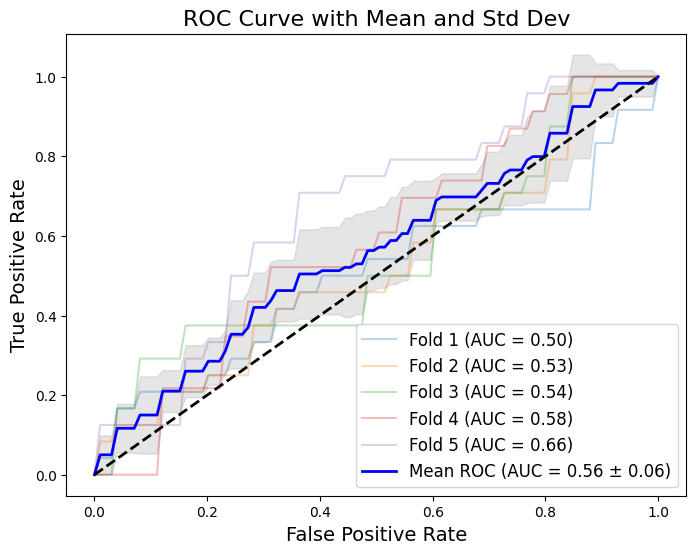

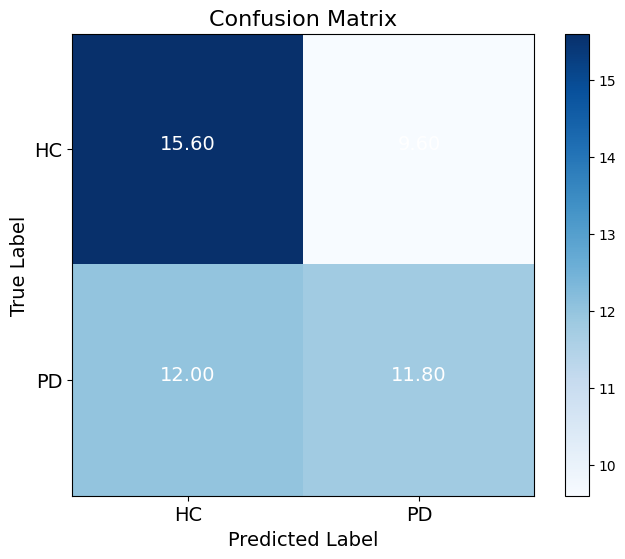

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mfcc'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_mobilenetv2_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\mfcc'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_vgg19_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 44s 6s/step - loss: 0.6920 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.4490
Epoch 2/50
7/7 [==============================] - 32s 5s/step - loss: 0.6917 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.4490
Epoch 3/50
7/7 [==============================] - 27s 4s/step - loss: 0.6915 - accuracy: 0.4949 - val_loss: 0.6939 - val_accuracy: 0.4490
Epoch 4/50
7/7 [==============================] - 27s 4s/step - loss: 0.6918 - accuracy: 0.5408 - val_loss: 0.6939 - val_accuracy: 0.4286
Epoch 5/50
7/7 [==============================] - 28s 4s/step - loss: 0.6915 - accuracy: 0.5510 - val_loss: 0.6939 - val_accuracy: 0.4286
Epoch 6/50
7/7 [==============================] - 27s 4s/step - loss: 0.6915 - accuracy: 0.5357 - val_loss: 0.6939 - val_accuracy: 0.4286
Epoch 7/50
7/7 [==================

In [ ]:
#for cqt

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 36s 4s/step - loss: 0.6955 - accuracy: 0.5153 - val_loss: 0.6970 - val_accuracy: 0.5102
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 0.6944 - accuracy: 0.5153 - val_loss: 0.6963 - val_accuracy: 0.5102
Epoch 3/50
7/7 [==============================] - 15s 2s/step - loss: 0.6939 - accuracy: 0.5153 - val_loss: 0.6962 - val_accuracy: 0.5102
Epoch 4/50
7/7 [==============================] - 15s 2s/step - loss: 0.6935 - accuracy: 0.5153 - val_loss: 0.6956 - val_accuracy: 0.5102
Epoch 5/50
7/7 [==============================] - 15s 2s/step - loss: 0.6928 - accuracy: 0.5153 - val_loss: 0.6952 - val_accuracy: 0.5102
Epoch 6/50
7/7 [==============================] - 15s 2s/step - loss: 0.6927 - accuracy: 0.5153 - val_loss: 0.6948 - val_accuracy: 0.5102
Epoch 7/50
7/7 [==================

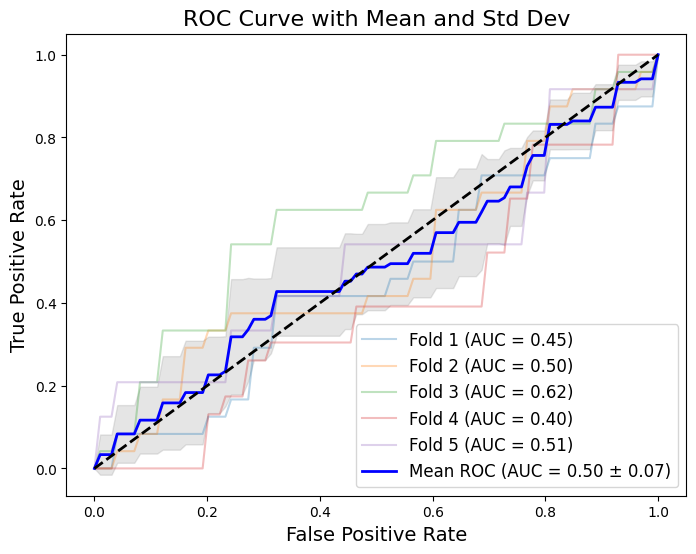

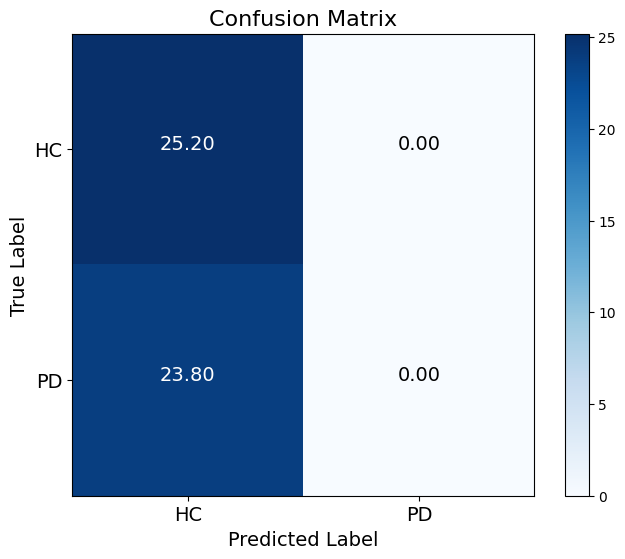

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\cqt'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_resnet50_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 26s 2s/step - loss: 0.8272 - accuracy: 0.4949 - val_loss: 0.8206 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 4s 612ms/step - loss: 0.7962 - accuracy: 0.5051 - val_loss: 0.7999 - val_accuracy: 0.4694
Epoch 3/50
7/7 [==============================] - 5s 716ms/step - loss: 0.7750 - accuracy: 0.4745 - val_loss: 0.7853 - val_accuracy: 0.4694
Epoch 4/50
7/7 [==============================] - 5s 729ms/step - loss: 0.7586 - accuracy: 0.4694 - val_loss: 0.7779 - val_accuracy: 0.4286
Epoch 5/50
7/7 [==============================] - 5s 700ms/step - loss: 0.7472 - accuracy: 0.4643 - val_loss: 0.7734 - val_accuracy: 0.4286
Epoch 6/50
7/7 [==============================] - 6s 826ms/step - loss: 0.7379 - accuracy: 0.4592 - val_loss: 0.7677 - val_accuracy: 0.4286
Epoch 7/50
7/7 [========

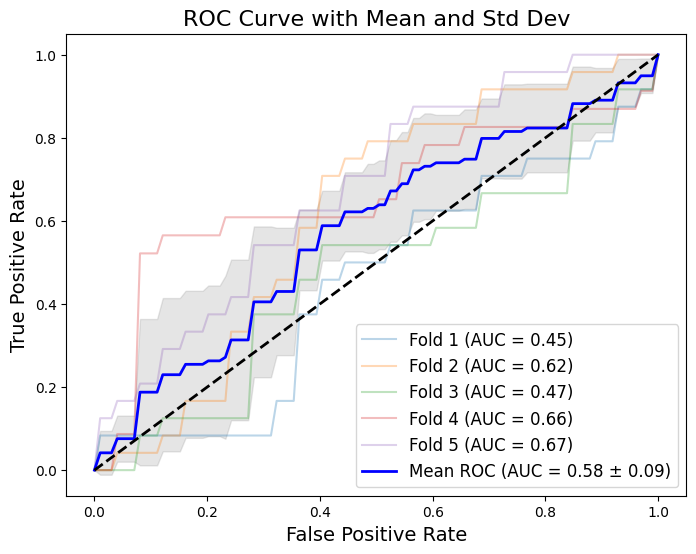

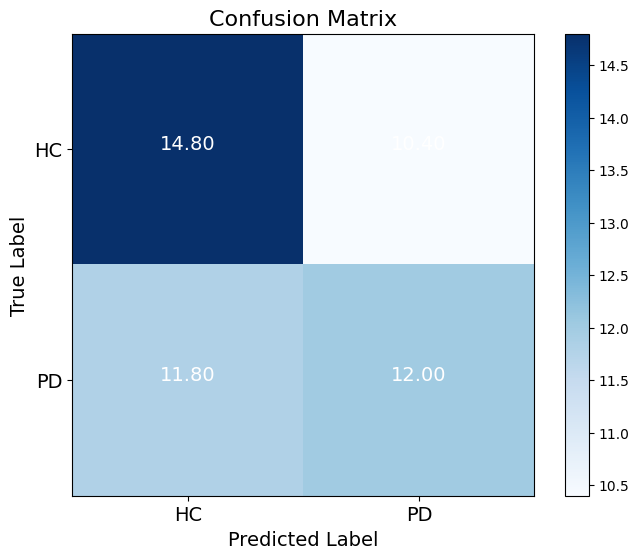

In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\cqt'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_mobilenetv2_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 44s 6s/step - loss: 0.8703 - accuracy: 0.4847 - val_loss: 0.8748 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 37s 5s/step - loss: 0.8519 - accuracy: 0.4847 - val_loss: 0.8585 - val_accuracy: 0.4898
Epoch 3/50
7/7 [==============================] - 37s 5s/step - loss: 0.8381 - accuracy: 0.4847 - val_loss: 0.8428 - val_accuracy: 0.4898
Epoch 4/50
7/7 [==============================] - 36s 5s/step - loss: 0.8221 - accuracy: 0.4847 - val_loss: 0.8278 - val_accuracy: 0.4898
Epoch 5/50
7/7 [==============================] - 36s 5s/step - loss: 0.8090 - accuracy: 0.4847 - val_loss: 0.8137 - val_accuracy: 0.4898
Epoch 6/50
7/7 [==============================] - 37s 5s/step - loss: 0.7962 - accuracy: 0.4847 - val_loss: 0.8011 - val_accuracy: 0.4898
Epoch 7/50
7/7 [==================

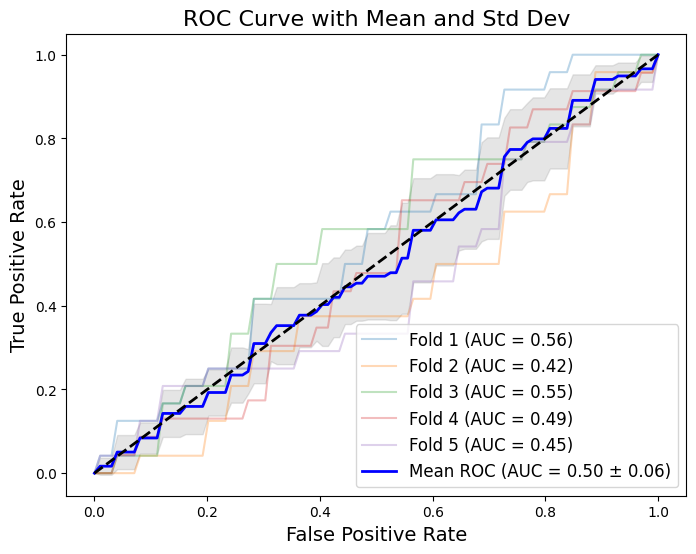

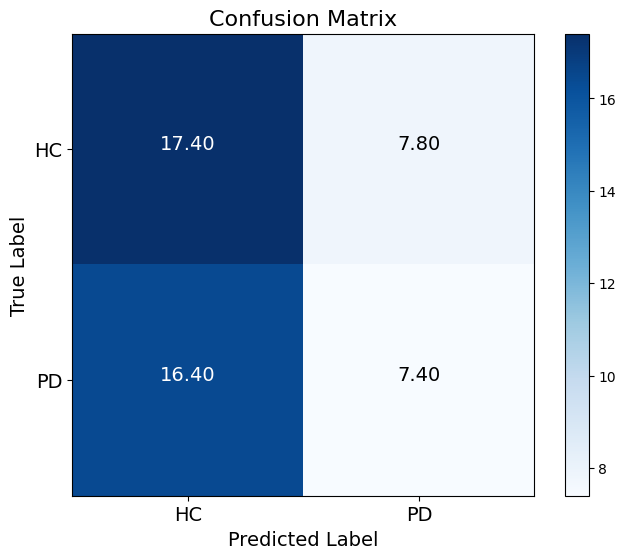

In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\cqt'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_vgg19_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

In [ ]:
#for stft

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 67s 6s/step - loss: 0.6933 - accuracy: 0.5204 - val_loss: 0.6917 - val_accuracy: 0.5102
Epoch 2/50
7/7 [==============================] - 23s 3s/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6918 - val_accuracy: 0.5306
Epoch 3/50
7/7 [==============================] - 23s 3s/step - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6918 - val_accuracy: 0.4898
Epoch 4/50
7/7 [==============================] - 24s 3s/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6919 - val_accuracy: 0.5510
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 0.6933 - accuracy: 0.4745 - val_loss: 0.6920 - val_accuracy: 0.5510
Epoch 6/50
7/7 [==============================] - 23s 3s/step - loss: 0.6931 - accuracy: 0.4745 - val_loss: 0.6920 - val_accuracy: 0.5306
Epoch 7/50
7/7 [==================

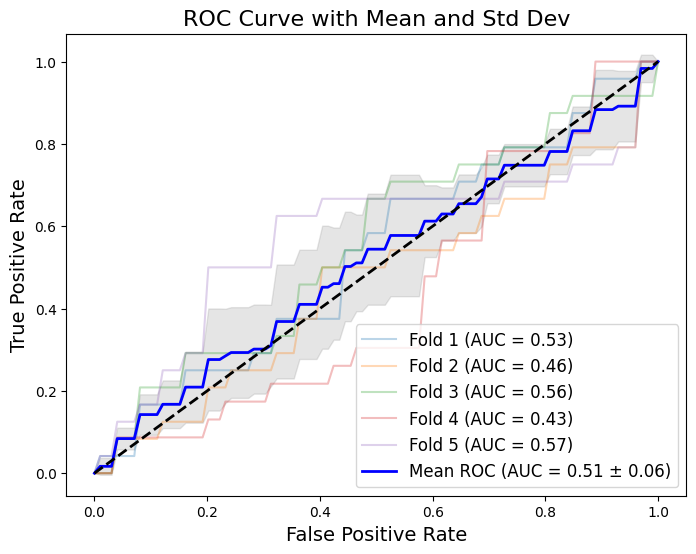

In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\stft'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_resnet50_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 43s 3s/step - loss: 0.8682 - accuracy: 0.5051 - val_loss: 0.8740 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 5s 715ms/step - loss: 0.8169 - accuracy: 0.5153 - val_loss: 0.8416 - val_accuracy: 0.4694
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.7814 - accuracy: 0.5306 - val_loss: 0.8239 - val_accuracy: 0.4490
Epoch 4/50
7/7 [==============================] - 6s 937ms/step - loss: 0.7582 - accuracy: 0.5255 - val_loss: 0.8133 - val_accuracy: 0.4490
Epoch 5/50
7/7 [==============================] - 6s 925ms/step - loss: 0.7403 - accuracy: 0.5459 - val_loss: 0.8070 - val_accuracy: 0.4694
Epoch 6/50
7/7 [==============================] - 6s 864ms/step - loss: 0.7269 - accuracy: 0.5561 - val_loss: 0.8047 - val_accuracy: 0.4694
Epoch 7/50
7/7 [===========

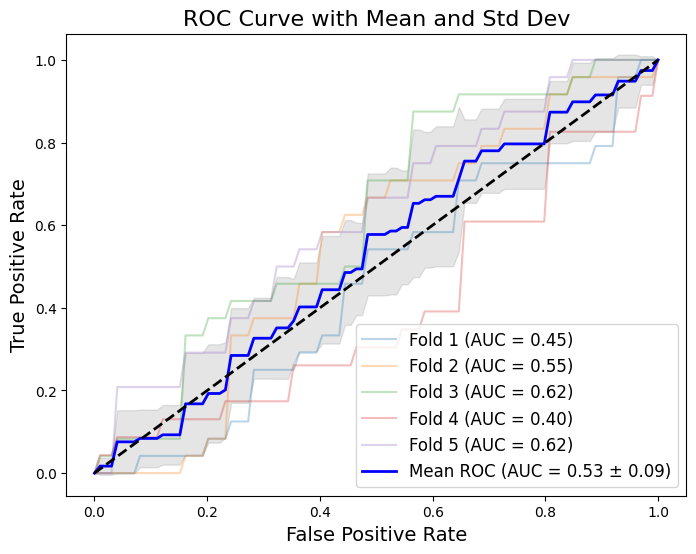

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\stft'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_mobilenetv2_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)

Starting evaluation...

Fold 1 - Speaker-Independent Evaluation
Loading training images...
Loading validation images...
Training model...
Epoch 1/50
7/7 [==============================] - 67s 8s/step - loss: 0.7421 - accuracy: 0.4847 - val_loss: 0.7476 - val_accuracy: 0.4898
Epoch 2/50
7/7 [==============================] - 56s 8s/step - loss: 0.7339 - accuracy: 0.4847 - val_loss: 0.7403 - val_accuracy: 0.4898
Epoch 3/50
7/7 [==============================] - 56s 8s/step - loss: 0.7274 - accuracy: 0.4847 - val_loss: 0.7340 - val_accuracy: 0.4898
Epoch 4/50
7/7 [==============================] - 58s 8s/step - loss: 0.7214 - accuracy: 0.4847 - val_loss: 0.7289 - val_accuracy: 0.4898
Epoch 5/50
7/7 [==============================] - 55s 8s/step - loss: 0.7170 - accuracy: 0.4847 - val_loss: 0.7247 - val_accuracy: 0.4898
Epoch 6/50
7/7 [==============================] - 56s 8s/step - loss: 0.7131 - accuracy: 0.4847 - val_loss: 0.7214 - val_accuracy: 0.4898
Epoch 7/50
7/7 [==================

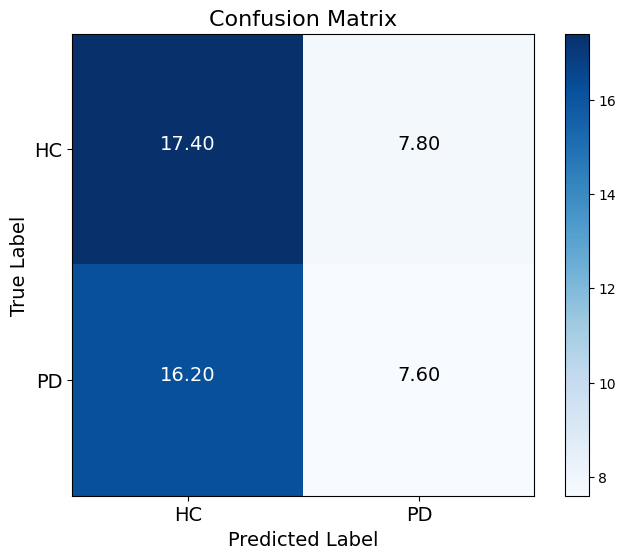

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, 
                            f1_score, precision_score, recall_score)
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\stft'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    
    # Handle different channel cases
    if len(image_array.shape) == 2:  # Grayscale (H,W)
        image_array = np.stack((image_array,)*3, axis=-1)  # Convert to RGB
    elif image_array.shape[2] == 4:  # RGBA
        image_array = image_array[:, :, :3]  # Drop alpha channel
    elif image_array.shape[2] == 1:  # Single channel
        image_array = np.concatenate([image_array]*3, axis=-1)  # Convert to RGB
    
    # Ensure we have exactly 3 channels
    if image_array.shape[2] != 3:
        raise ValueError(f"Unexpected number of channels in image: {image_array.shape}")
    
    return image_array

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.lower().endswith((".png")):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        print("Loading training images...")
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        print("Loading validation images...")
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile model
        input_shape = (128, 128, 3)
        model = build_vgg19_model(input_shape, num_classes=2)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
       
        # Train model
        print("Training model...")
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        print("Evaluating model...")
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.0
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
print("Starting evaluation...")
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)